---
# I. Môi trường triển khai
---

In [ ]:
# Cài đặt thư viện dùng cho thuật toán ECLAT
# ------------------------------------------------------------------------------
! pip install pyECLAT

In [ ]:
# Môi trường lập trình
# ------------------------------------------------------------------------------
from google.colab import drive
drive.mount("/content/gdrive")
folder = '/content/gdrive/MyDrive/Machine Learning'

In [ ]:
# Các thư viện cơ bản
# ------------------------------------------------------------------------------
import pandas as pd
import numpy as np
import time
import math
import re
import itertools
import warnings
warnings.filterwarnings('ignore')

# Các thư viện khai phá luật kết hợp
# ------------------------------------------------------------------------------
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import association_rules
from mlxtend.frequent_patterns import apriori
from pyECLAT import ECLAT

# Visualization
# ------------------------------------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px


---
# II. Mô tả dữ liệu
---

Bộ dữ liệu ghi lại mặt hàng trong giỏ hàng siêu thị của các khách hàng
*   Mỗi dòng đại diện cho một giao dịch
*   Mỗi cột đại diện cho một item trong giỏ hàng



In [ ]:
# Tải bộ dữ liệu "Market Basket Analysis 4.cvs" lên
# ------------------------------------------------------------------------------
df = pd.read_csv('/content/Market Basket Analysis 4.csv', header=None)

In [ ]:
# Quan sát các dòng dữ liệu đầu
# ------------------------------------------------------------------------------
df.head()

,0,1,2,3,4,5,6,7,8,9,10
0,whole milk,pastry,salty snack,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,sausage,whole milk,semi-finished bread,yogurt,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,soda,pickled vegetables,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,canned beer,misc. beverages,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,sausage,hygiene articles,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Quan sát các dòng dữ liệu cuối
# ------------------------------------------------------------------------------
df.tail()

,0,1,2,3,4,5,6,7,8,9,10
14958,butter milk,whipped/sour cream,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14959,bottled water,herbs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14960,fruit/vegetable juice,onions,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14961,bottled beer,other vegetables,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14962,soda,root vegetables,semi-finished bread,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Kích thước bộ dữ liệu
# ------------------------------------------------------------------------------
df.shape

(14963, 11)

In [ ]:
# Quan sát các cột dữ liệu
# ------------------------------------------------------------------------------
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14963 entries, 0 to 14962
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       14963 non-null  object
 1   1       14963 non-null  object
 2   2       4883 non-null   object
 3   3       2185 non-null   object
 4   4       795 non-null    object
 5   5       451 non-null    object
 6   6       276 non-null    object
 7   7       196 non-null    object
 8   8       51 non-null     object
 9   9       1 non-null      object
 10  10      1 non-null      object
dtypes: object(11)
memory usage: 1.3+ MB


# III. Phân tích khám phá dữ liệu (EDA)

## 1. Xử lý trùng trong giao dịch

In [ ]:
# Tính tổng số lượng từng sản phẩm
# ------------------------------------------------------------------------------
items_total = df.apply(pd.Series.value_counts).sum(axis=1)
items_total = pd.DataFrame({'items': items_total.index, 'transactions': items_total.values})
items_total.sort_values('transactions', ascending=False).head(15).reset_index(drop = True).style.background_gradient(cmap='Blues')

,items,transactions
0,whole milk,2502.000000
1,other vegetables,1898.000000
2,rolls/buns,1716.000000
3,soda,1514.000000
4,yogurt,1334.000000
5,root vegetables,1071.000000
6,tropical fruit,1032.000000
7,bottled water,933.000000
8,sausage,924.000000
9,citrus fruit,812.000000


In [ ]:
# Kiểm tra tính duy nhất của các item trong mỗi giao dịch
# ------------------------------------------------------------------------------
df['num_uniq'] = df.iloc[:,0:11].apply(pd.Series.nunique, axis=1) #Số item duy nhất trong giao dịch
df['num_item'] = df.iloc[:,0:11].count(axis=1) #Số item trong giao dịch
print("--- CÁC GIAO DỊCH CÓ CHỨA ITEM TRÙNG LẶP ---")
df[df['num_uniq'] != df['num_item']]

--- CÁC GIAO DỊCH CÓ CHỨA ITEM TRÙNG LẶP ---


,0,1,2,3,4,5,6,7,8,9,10,num_uniq,num_item
15,rolls/buns,rolls/buns,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2
27,rolls/buns,rolls/buns,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2
31,whole milk,frankfurter,chicken,frankfurter,flour,chocolate,bottled beer,rolls/buns,NaN,NaN,NaN,7,8
33,tropical fruit,soda,yogurt,root vegetables,yogurt,domestic eggs,white wine,photo/film,NaN,NaN,NaN,7,8
102,root vegetables,whipped/sour cream,root vegetables,canned beer,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14841,bottled water,root vegetables,bottled water,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,3
14863,beef,beef,margarine,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,3
14901,frankfurter,margarine,whole milk,soda,margarine,brown bread,margarine,frozen vegetables,NaN,NaN,NaN,6,8
14923,candles,rolls/buns,other vegetables,rolls/buns,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,4


In [ ]:
# Xử lý các giao dịch và đưa vào df mới sau đó kiểm tra lại tính duy nhất
# ------------------------------------------------------------------------------
df_cleaned = []

df = df.replace(np.nan, None)

for _, row in df.iloc[:,0:11].iterrows():
  temp = []
  for column, value in row.iteritems():
    if (value is not None) and (value not in temp):
      i = f"{value}"
      temp.append(i)
  df_cleaned.append(temp)

df_cleaned = pd.DataFrame(df_cleaned)
df_cleaned['num_uniq'] = df_cleaned.iloc[:,0:10].apply(pd.Series.nunique, axis=1)
df_cleaned['num_item'] = df_cleaned.iloc[:,0:10].count(axis=1)
print('Số giao dịch có chứa item trùng lặp là:', len(df_cleaned[df_cleaned['num_uniq'] != df_cleaned['num_item']]))

Số giao dịch có chứa item trùng lặp là: 0


In [ ]:
df_cleaned

,0,1,2,3,4,5,6,7,8,9,num_uniq,num_item
0,whole milk,pastry,salty snack,None,None,None,None,None,None,None,3,3
1,sausage,whole milk,semi-finished bread,yogurt,None,None,None,None,None,None,4,4
2,soda,pickled vegetables,None,None,None,None,None,None,None,None,2,2
3,canned beer,misc. beverages,None,None,None,None,None,None,None,None,2,2
4,sausage,hygiene articles,None,None,None,None,None,None,None,None,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...
14958,butter milk,whipped/sour cream,None,None,None,None,None,None,None,None,2,2
14959,bottled water,herbs,None,None,None,None,None,None,None,None,2,2
14960,fruit/vegetable juice,onions,None,None,None,None,None,None,None,None,2,2
14961,bottled beer,other vegetables,None,None,None,None,None,None,None,None,2,2


In [ ]:
# Thu được DataFrame sau khi xử lý (Vì lọc item trùng nên số cột cũng giảm)
# ------------------------------------------------------------------------------
df_cleaned = df_cleaned.iloc[:,0:10]
df_cleaned = df_cleaned.fillna(value= float('nan'))
df_cleaned

,0,1,2,3,4,5,6,7,8,9
0,whole milk,pastry,salty snack,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,sausage,whole milk,semi-finished bread,yogurt,NaN,NaN,NaN,NaN,NaN,NaN
2,soda,pickled vegetables,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,canned beer,misc. beverages,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,sausage,hygiene articles,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
14958,butter milk,whipped/sour cream,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14959,bottled water,herbs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14960,fruit/vegetable juice,onions,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14961,bottled beer,other vegetables,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Tính tổng số lượng từng sản phẩm sau khi xử lý
# ------------------------------------------------------------------------------
items_total_clean = df_cleaned.apply(pd.Series.value_counts).sum(axis=1)
items_total_clean = pd.DataFrame({'items': items_total_clean.index, 'transactions': items_total_clean.values})
items_total_clean.sort_values('transactions', ascending=False).head(15).reset_index(drop = True).style.background_gradient(cmap='Blues')

,items,transactions
0,whole milk,2363.000000
1,other vegetables,1827.000000
2,rolls/buns,1646.000000
3,soda,1453.000000
4,yogurt,1285.000000
5,root vegetables,1041.000000
6,tropical fruit,1014.000000
7,bottled water,908.000000
8,sausage,903.000000
9,citrus fruit,795.000000


## 2. Phân tích sản phẩm

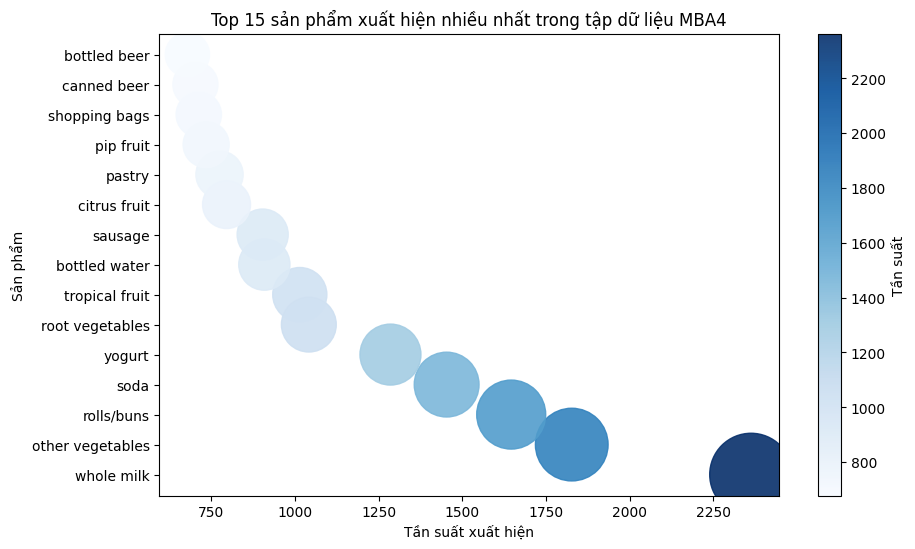

In [ ]:
# Biểu đồ scarter plot thể hiện top 15 sản phẩm được xuất hiện trong giỏ hàng nhiều nhất
# ------------------------------------------------------------------------------
items_list = df_cleaned.values.flatten()
frequency = pd.Series(items_list).value_counts().head(15)
fig, ax = plt.subplots(figsize=(10, 6))
scatter = ax.scatter(frequency.values, frequency.index, s=frequency.values * 1.5, alpha=0.9, c=frequency.values, cmap='Blues')
ax.set_xlabel('Tần suất xuất hiện')
ax.set_ylabel('Sản phẩm')
ax.set_title('Top 15 sản phẩm xuất hiện nhiều nhất trong tập dữ liệu MBA4')
cbar = plt.colorbar(scatter)
cbar.ax.set_ylabel('Tần suất')
plt.show()

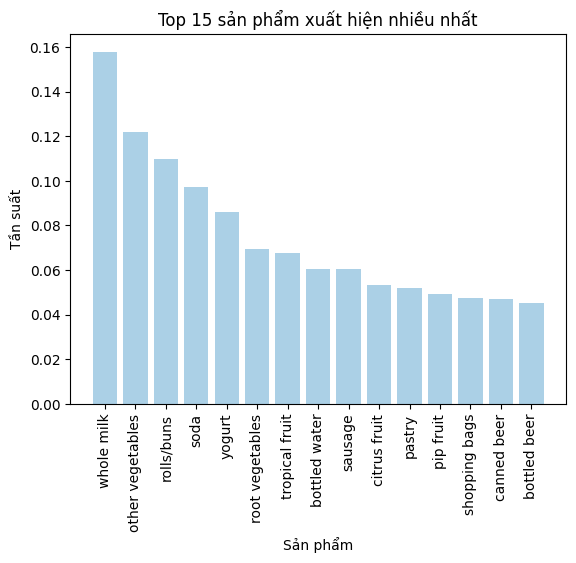

In [ ]:
# Biểu đồ bar plot thể hiện tần suất của top 15 sản phẩm được xuất hiện trong giỏ hàng nhiều nhất
# ------------------------------------------------------------------------------
product_counts = df_cleaned.apply(pd.Series.value_counts)
total_samples = len(df)
product_frequencies = product_counts / total_samples
top_products = product_frequencies.sum(axis=1).sort_values(ascending=False).head(15)
plt.bar(top_products.index, top_products.values, color='#ABD0E6')
plt.xlabel('Sản phẩm')
plt.ylabel('Tần suất')
plt.title('Top 15 sản phẩm xuất hiện nhiều nhất')
plt.xticks(rotation=90)
plt.show()

In [ ]:
# Tree Map biểu diễn số lượng top 50 mặt hàng xuất hiện nhiều nhất trong giỏ hàng
# ------------------------------------------------------------------------------
items_total_clean["all"] = "Tree Map"
items_total_clean = items_total_clean.sort_values('transactions', ascending=False)

fig = px.treemap(items_total_clean.head(50), path=['all', "items"], values='transactions',
                 color=items_total_clean["transactions"].head(50), hover_data=['items'],
                 color_continuous_scale='Blues',
                 title="Tree Map số lượng top 50 item xuất hiện nhiều nhất trong giỏ hàng")
fig.show()

## 3. Phân tích giao dịch

In [ ]:
# Tính số item trong giao dịch và số lượng giao dịch
# ------------------------------------------------------------------------------
items_per_transaction = df_cleaned.count(axis=1)
items_per_transaction = items_per_transaction.value_counts()
items_per_transaction

2     10012
3      2727
4      1273
5       338
1       205
6       179
7       113
8        96
9        19
10        1
dtype: int64

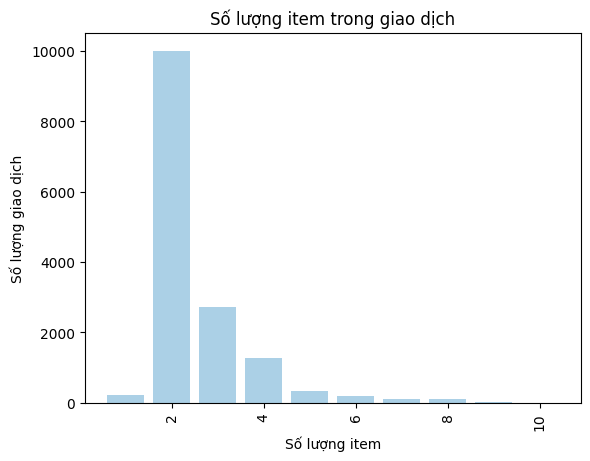

In [ ]:
# Biểu đồ bar plot thể hiện số lượng giao dịch ứng với mỗi số lượng item trong giao dịch
# ------------------------------------------------------------------------------
plt.bar(items_per_transaction.index, items_per_transaction.values, color='#ABD0E6')
plt.xlabel('Số lượng item')
plt.ylabel('Số lượng giao dịch')
plt.title('Số lượng item trong giao dịch')
plt.xticks(rotation=90)
plt.show()

---
# IV. Frequent Pattern Algorithms
---
Xét 3 thuật toán:
* Thuật toán ECLAT (thư viện pyECLAT)
* Thuật toán ECLAT (mô phỏng)
* Thuật toán Apriori

In [ ]:
# Nhập các ngưỡng tối thiểu khi khai phá dữ liệu
# ------------------------------------------------------------------------------
min_support = eval(input("Nhập độ hỗ trợ tối thiểu - minSup (e.g. 0.01): "))
min_confidence = eval(input("Nhập độ chắc chắn tối thiểu - minConf (e.g. 0.3): "))

Nhập độ hỗ trợ tối thiểu - minSup (e.g. 0.01): 0.001
Nhập độ chắc chắn tối thiểu - minConf (e.g. 0.3): 0.03


## Thuật toán ECLAT (PyECLAT lib)

In [ ]:
# Sử dụng hàm ECLAT thư viện pyECLAT để chuyển dạng dữ liệu thành bảng boolean
#   + Mỗi hàng thể hiện một giao dịch
#   + Mỗi cột thể hiện một mặt hàng trong toàn tập dữ liệu
# Ô sẽ mang giá trị 1 nếu mặt hàng đó có trong giao dịch và 0 nếu ngược lại
# ------------------------------------------------------------------------------
df1 = df_cleaned
eclat = ECLAT(data=df1)
eclat.df_bin

,brown bread,cleaner,seasonal products,mayonnaise,bags,fruit/vegetable juice,canned vegetables,processed cheese,skin care,syrup,...,chocolate,sugar,condensed milk,nuts/prunes,liquor,sauces,baby cosmetics,semi-finished bread,jam,bathroom cleaner
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14958,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14959,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14960,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14961,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Khai phá các tập phổ biến có sự kết hợp của 1 đến 2 item
# ------------------------------------------------------------------------------
start_time = time.time()

min_combination = 1
max_combination = 2
rule_indices, rule_supports = eclat.fit(min_support=min_support,
                                        min_combination = min_combination,
                                        max_combination = max_combination,
                                        separator = ', ',
                                        verbose = True)

elapsed_time_eclat1 = time.time() - start_time

Combination 1 by 1


149it [00:03, 45.59it/s]


Combination 2 by 2


11026it [02:02, 89.91it/s] 


In [ ]:
# Dữ liệu dưới dạng Vertical được tạo bởi pyECLAT
# ------------------------------------------------------------------------------
rule_indices

In [ ]:
# Chuyển các khóa của tập phổ biến thành frozenset và đứa vào một list itemsets
# ------------------------------------------------------------------------------
elapsed_time_eclat1 = elapsed_time_eclat1 - time.time()
itemsets = []
for i in list(rule_supports.keys()):
  i = i.split(', ')
  i = (frozenset(i))
  itemsets.append(i)

# Ta được tạo được một DataFrame gồm các tập phổ biến và support của chúng
# ------------------------------------------------------------------------------
freq_itemsets = pd.DataFrame({'support': list(rule_supports.values()),
                              'itemsets': itemsets})

# Sử dụng association_rules để khai phá các luật từ tập phổ biến tìm được
# ------------------------------------------------------------------------------
rule_ECLAT = association_rules(freq_itemsets, metric="confidence", min_threshold= min_confidence)
rule_ECLAT = rule_ECLAT[rule_ECLAT.lift > 1]
rule_ECLAT = rule_ECLAT.reset_index(drop=True)

elapsed_time_eclat1 = elapsed_time_eclat1 + time.time()
rule_ECLAT

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(frankfurter),(brown bread),0.037760,0.037626,0.001537,0.040708,1.081906,1.163689e-04,1.003213,0.078676
1,(brown bread),(frankfurter),0.037626,0.037760,0.001537,0.040853,1.081906,1.163689e-04,1.003224,0.078665
2,(canned beer),(brown bread),0.046916,0.037626,0.002406,0.051282,1.362937,6.406768e-04,1.014394,0.279398
3,(brown bread),(canned beer),0.037626,0.046916,0.002406,0.063943,1.362937,6.406768e-04,1.018191,0.276701
4,(pastry),(brown bread),0.051728,0.037626,0.002005,0.038760,1.030127,5.863558e-05,1.001179,0.030841
...,...,...,...,...,...,...,...,...,...,...
143,(butter),(citrus fruit),0.035220,0.053131,0.001938,0.055028,1.035712,6.682705e-05,1.002008,0.035739
144,(bottled beer),(sausage),0.045312,0.060349,0.003342,0.073746,1.222000,6.070623e-04,1.014464,0.190292
145,(sausage),(bottled beer),0.060349,0.045312,0.003342,0.055371,1.222000,6.070623e-04,1.010649,0.193337
146,(citrus fruit),(beef),0.053131,0.033950,0.001804,0.033962,1.000349,6.297697e-07,1.000012,0.000369


## Thuật toán ECLAT (mô phỏng)

In [ ]:
# Thay thế các giá trị NaN thành các giá trị None
# ------------------------------------------------------------------------------
df2 = df_cleaned.replace(np.nan, None)
df2

,0,1,2,3,4,5,6,7,8,9
0,whole milk,pastry,salty snack,None,None,None,None,None,None,None
1,sausage,whole milk,semi-finished bread,yogurt,None,None,None,None,None,None
2,soda,pickled vegetables,None,None,None,None,None,None,None,None
3,canned beer,misc. beverages,None,None,None,None,None,None,None,None
4,sausage,hygiene articles,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...
14958,butter milk,whipped/sour cream,None,None,None,None,None,None,None,None
14959,bottled water,herbs,None,None,None,None,None,None,None,None
14960,fruit/vegetable juice,onions,None,None,None,None,None,None,None,None
14961,bottled beer,other vegetables,None,None,None,None,None,None,None,None


In [ ]:
# Chuyển Data Fomart từ dạng ngang (Horizontal) sang dạng dọc (Vertical)
# ------------------------------------------------------------------------------
vertical_data={}

for i in range(df2.shape[0]):
  for j in range(10):
    if df2.iloc[i][j] is not None:
      if(vertical_data.get(df2.iloc[i][j])):
        vertical_data[df2.iloc[i][j]].append(str(i))
      else:
        vertical_data[df2.iloc[i][j]] = [str(i)]

In [ ]:
# Tần số hỗ trợ (Frequency Support)
# ------------------------------------------------------------------------------
freq_sup = {}
for item in vertical_data:
    freq_sup[item] = len(vertical_data[item])

In [ ]:
# Xây dựng một số hàm đơn giản để code ngắn gọn hơn và dễ dàng xử lý các tập phổ biến
#  + Chuyển list thành string
#  + Chuyển string thành list
# ------------------------------------------------------------------------------
def list_to_str(l):
    l_list = list(l)
    l_list.sort()
    return ','.join(l_list)

def str_to_list(s):
    return s.split(',')

In [ ]:
# Hàm tìm kiếm các tập phổ biến theo đề xuất của (Yin & Han, 2003)
# ------------------------------------------------------------------------------
start_time = time.time()

new_temp_data = vertical_data.copy()
data_temp = vertical_data.copy()
key_set = set()
item_list = []
frequent_item_set = {}
iteration = 0

for item in new_temp_data:
  if(len(new_temp_data[item]) < (min_support*len(df_cleaned))):
    del data_temp[item]

while True:
  iteration+=1

  temp_temp = new_temp_data.copy()
  item_list = list(temp_temp.keys())
  if len(item_list) == 0:
    break
  new_temp_data = {}

  for i in range(len(item_list)):
    for j in range(i+1, len(item_list)):
      if (iteration == 1) or (len(list(set(str_to_list(item_list[i])).intersection(set(str_to_list(item_list[j])))))==iteration-1):
        key_set = set()
        key_set.update(str_to_list(item_list[i]))
        key_set.update(str_to_list(item_list[j]))
        key_set_str = list_to_str(key_set)
        temp = list(set(temp_temp[item_list[i]])&set(temp_temp[item_list[j]]))
        if len(temp) >= (min_support*len(df_cleaned)):
          new_temp_data[key_set_str] = temp
          freq_sup[key_set_str] = len(new_temp_data[key_set_str])
  data_temp.update(new_temp_data)

frequent_item_set = data_temp
elapsed_time_eclat2 = time.time() - start_time

In [ ]:
# Tìm luật kết hợp mạnh từ tập phổ biến tìm được ở trên
# ------------------------------------------------------------------------------
start_time = time.time()

frequent_item_set_keys = list(frequent_item_set.keys())
ECLAT_association_rules = []

for frequent_item in frequent_item_set_keys:
  for i in range(1, len(str_to_list(frequent_item))):
    for item_combination in itertools.combinations(str_to_list(frequent_item), i):
      str_item_combination_A = list_to_str(list(item_combination))
      str_item_combination_B = list_to_str(list(set(str_to_list(frequent_item))-set(list(item_combination))))
      conf = freq_sup[frequent_item] / freq_sup[str_item_combination_A]
      if(conf >= min_confidence):
        ECLAT_association_rules.append((str_item_combination_A, str_item_combination_B,
                                         freq_sup[str_item_combination_A]/len(df),
                                         freq_sup[str_item_combination_B]/len(df),
                                         len(frequent_item_set[frequent_item])/len(df),
                                         conf))

elapsed_time_eclat2 = elapsed_time_eclat2 + time.time() - start_time

In [ ]:
# Chuyển các luật kết hợp sang DataFrame để quan sát kết quả
# ------------------------------------------------------------------------------
start_time = time.time()

rule_ECLAT_2 = pd.DataFrame(ECLAT_association_rules, columns =['antecedents', 'consequents', 'antecedent_support', 'consequent_support', 'support', 'confidence'])
rule_ECLAT_2['lift'] = rule_ECLAT_2['confidence']/rule_ECLAT_2['consequent_support']
rule_ECLAT_2 = rule_ECLAT_2[rule_ECLAT_2.lift > 1]
rule_ECLAT_2 = rule_ECLAT_2.reset_index(drop=True)

elapsed_time_eclat2 = elapsed_time_eclat2 + time.time() - start_time
rule_ECLAT_2

,antecedents,consequents,antecedent_support,consequent_support,support,confidence,lift
0,semi-finished bread,whole milk,0.009490,0.157923,0.001671,0.176056,1.114825
1,detergent,whole milk,0.008621,0.157923,0.001403,0.162791,1.030824
2,ham,whole milk,0.017109,0.157923,0.002740,0.160156,1.014142
3,pastry,sausage,0.051728,0.060349,0.003208,0.062016,1.027617
4,sausage,pastry,0.060349,0.051728,0.003208,0.053156,1.027617
...,...,...,...,...,...,...,...
158,"rolls/buns,yogurt",whole milk,0.007819,0.157923,0.001337,0.170940,1.082428
159,"whole milk,yogurt",rolls/buns,0.011161,0.110005,0.001337,0.119760,1.088685
160,"other vegetables,rolls/buns",soda,0.010559,0.097106,0.001136,0.107595,1.108013
161,"other vegetables,soda",rolls/buns,0.009691,0.110005,0.001136,0.117241,1.065785


---
## Thuật toán Apriori

In [ ]:
# Đưa các giao dịch vào list
# Mỗi list là một itemset chứa các item là mặt hàng mà khách hàng mua
# ------------------------------------------------------------------------------
transaction = []

for _, row in df2.iterrows():
  temp = []
  for column, value in row.iteritems():
    if value is not None:
      i = f"{value}"
      temp.append(i)
  transaction.append(temp)

In [ ]:
# TransactionEncoder để chuyển dữ liệu giao dịch thành mảng one-hot encoder boolean
# ------------------------------------------------------------------------------
te = TransactionEncoder()
te_ary = te.fit(transaction).transform(transaction)
df3 = pd.DataFrame(te_ary, columns=te.columns_)
df3

,Instant food products,UHT-milk,abrasive cleaner,artif. sweetener,baby cosmetics,bags,baking powder,bathroom cleaner,beef,berries,...,turkey,vinegar,waffles,whipped/sour cream,whisky,white bread,white wine,whole milk,yogurt,zwieback
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,True,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14958,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
14959,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
14960,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
14961,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [ ]:
len(transaction)

14963

In [ ]:
count = 0
for i in transaction:
  for j in i:
    if j == 'whole milk':
      count += 1
print(count)

df3['whole milk'].value_counts()

2363


False    12600
True      2363
Name: whole milk, dtype: int64

In [ ]:
# Sử dụng thuật toán Apriori (thư viện mlxtend) để khai pháp tập kết hợp
# ------------------------------------------------------------------------------
start_time = time.time()

df_apriori = apriori(df3, min_support=min_support, use_colnames=True)
df_apriori.itemsets

elapsed_time_apriori = time.time() - start_time

In [ ]:
# Sử dụng association_rules để khai phá các luật từ tập phổ biến tìm được
# Ngưỡng yêu cầu là minConf = 0.03 và lift tối thiểu là 1
# ------------------------------------------------------------------------------
start_time = time.time()

rule_APRIORI = association_rules(df_apriori, metric="confidence", min_threshold= min_confidence)
rule_APRIORI = rule_APRIORI[rule_APRIORI.lift > 1]
rule_APRIORI = rule_APRIORI.reset_index(drop=True)

elapsed_time_apriori = elapsed_time_apriori + time.time() - start_time
rule_APRIORI

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(UHT-milk),(tropical fruit),0.021386,0.067767,0.001537,0.071875,1.060617,8.785064e-05,1.004426,0.058402
1,(beef),(brown bread),0.033950,0.037626,0.001537,0.045276,1.203301,2.597018e-04,1.008012,0.174891
2,(brown bread),(beef),0.037626,0.033950,0.001537,0.040853,1.203301,2.597018e-04,1.007196,0.175559
3,(citrus fruit),(beef),0.053131,0.033950,0.001804,0.033962,1.000349,6.297697e-07,1.000012,0.000369
4,(beef),(citrus fruit),0.033950,0.053131,0.001804,0.053150,1.000349,6.297697e-07,1.000020,0.000361
...,...,...,...,...,...,...,...,...,...,...
158,"(sausage, whole milk)",(soda),0.008955,0.097106,0.001069,0.119403,1.229612,1.996772e-04,1.025320,0.188423
159,"(soda, sausage)",(whole milk),0.005948,0.157923,0.001069,0.179775,1.138374,1.299782e-04,1.026642,0.122281
160,"(yogurt, whole milk)",(sausage),0.011161,0.060349,0.001470,0.131737,2.182917,7.967480e-04,1.082219,0.548014
161,"(yogurt, sausage)",(whole milk),0.005748,0.157923,0.001470,0.255814,1.619866,5.626300e-04,1.131541,0.384877


---
# V. Kết quả mô hình
---
Tiến hành so sánh 3 thuật toán:
* Thời gian thực hiện
* Các chỉ số Support, Confidence, Lift...

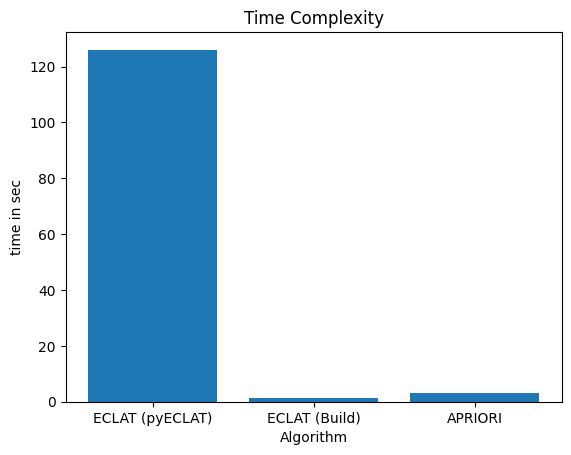

In [ ]:
x = ["ECLAT (pyECLAT)", "ECLAT (Build)", "APRIORI"]
y = [elapsed_time_eclat1, elapsed_time_eclat2, elapsed_time_apriori]

plt.bar(x, y)
plt.xlabel("Algorithm")
plt.ylabel("time in sec")
plt.title("Time Complexity")
plt.show()

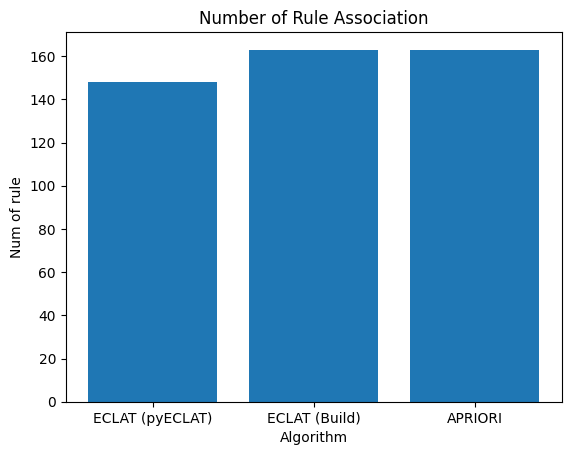

In [ ]:
x = ["ECLAT (pyECLAT)", "ECLAT (Build)", "APRIORI"]
y = [len(rule_ECLAT), len(rule_ECLAT_2), len(rule_APRIORI)]

plt.bar(x, y)
plt.xlabel("Algorithm")
plt.ylabel("Num of rule")
plt.title("Number of Rule Association")
plt.show()

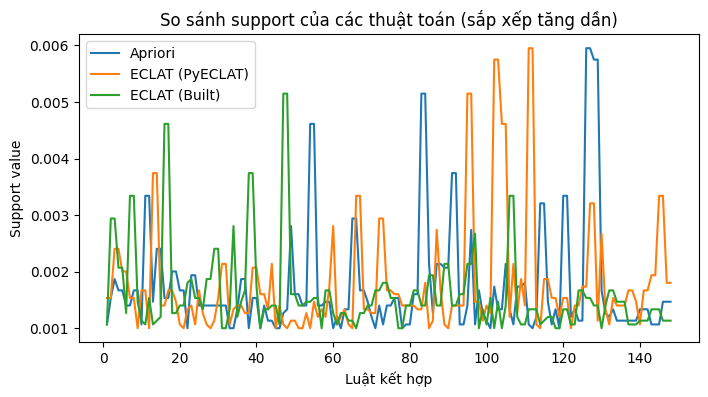

In [ ]:
k = min(len(rule_APRIORI), len(rule_ECLAT), len(rule_ECLAT_2))
x =  [i for i in range(1, k+1)]
y1 = rule_APRIORI["support"].tail(k)
y2 = rule_ECLAT["support"].tail(k)
y3 = rule_ECLAT_2["support"].tail(k)

plt.figure(figsize=(8,4))
plt.plot(x, y1, label='Apriori')
plt.plot(x, y2, label='ECLAT (PyECLAT)')
plt.plot(x, y3, label='ECLAT (Built)')

plt.xlabel('Luật kết hợp')
plt.ylabel('Support value')
plt.title('So sánh support của các thuật toán (sắp xếp tăng dần)')

plt.legend()
plt.show()

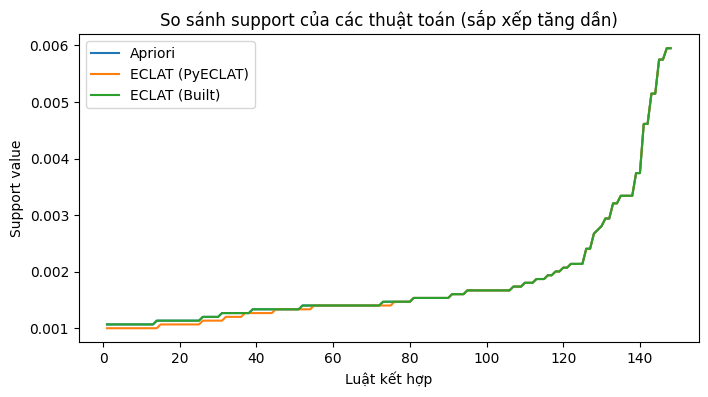

In [ ]:
k = min(len(rule_APRIORI), len(rule_ECLAT), len(rule_ECLAT_2))
x =  [i for i in range(1, k+1)]
y1 = rule_APRIORI["support"].sort_values().tail(k)
y2 = rule_ECLAT["support"].sort_values().tail(k)
y3 = rule_ECLAT_2["support"].sort_values().tail(k)

plt.figure(figsize=(8,4))
plt.plot(x, y1, label='Apriori')
plt.plot(x, y2, label='ECLAT (PyECLAT)')
plt.plot(x, y3, label='ECLAT (Built)')

plt.xlabel('Luật kết hợp')
plt.ylabel('Support value')
plt.title('So sánh support của các thuật toán (sắp xếp tăng dần)')

plt.legend()
plt.show()

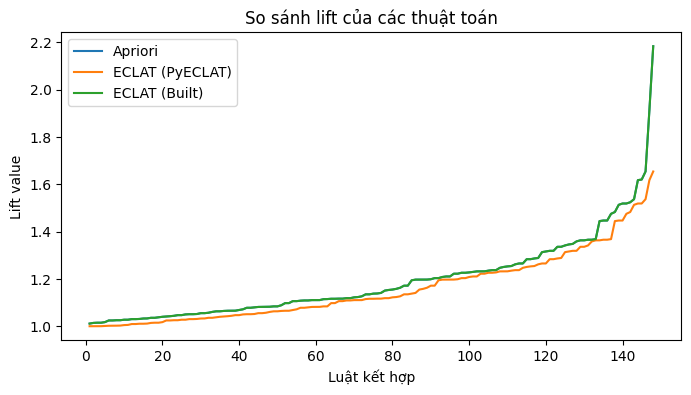

In [ ]:
k = min(len(rule_APRIORI), len(rule_ECLAT), len(rule_ECLAT_2))
x =  [i for i in range(1, k+1)]
y1 = rule_APRIORI["lift"].sort_values().tail(k)
y2 = rule_ECLAT["lift"].sort_values().tail(k)
y3 = rule_ECLAT_2["lift"].sort_values().tail(k)

plt.figure(figsize=(8,4))
plt.plot(x, y1, label='Apriori')
plt.plot(x, y2, label='ECLAT (PyECLAT)')
plt.plot(x, y3, label='ECLAT (Built)')

plt.xlabel('Luật kết hợp')
plt.ylabel('Lift value')
plt.title('So sánh lift của các thuật toán')

plt.legend()
plt.show()

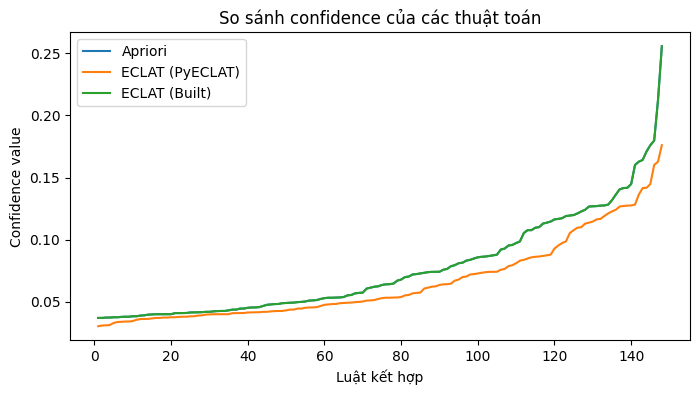

In [ ]:
k = min(len(rule_APRIORI), len(rule_ECLAT), len(rule_ECLAT_2))
x =  [i for i in range(1, k+1)]
y1 = rule_APRIORI["confidence"].sort_values().tail(k)
y2 = rule_ECLAT["confidence"].sort_values().tail(k)
y3 = rule_ECLAT_2["confidence"].sort_values().tail(k)

plt.figure(figsize=(8,4))
plt.plot(x, y1, label='Apriori')
plt.plot(x, y2, label='ECLAT (PyECLAT)')
plt.plot(x, y3, label='ECLAT (Built)')

plt.xlabel('Luật kết hợp')
plt.ylabel('Confidence value')
plt.title('So sánh confidence của các thuật toán')

plt.legend()
plt.show()

In [ ]:
fig = px.scatter(rule_ECLAT, x = 'support', y = 'lift',
                 color = 'confidence', color_continuous_scale=px.colors.sequential.Viridis,
                 title = 'Mối quan hệ giữa support, confidence và lift trong thuật toán ECLAT (pyECLAT)')
fig.show()

In [ ]:
fig = px.scatter(rule_ECLAT_2, x = 'support', y = 'lift',
                 color = 'confidence', color_continuous_scale=px.colors.sequential.Viridis,
                 title = 'Mối quan hệ giữa support, confidence và lift trong thuật toán ECLAT (built)')
fig.show()

In [ ]:
fig = px.scatter(rule_APRIORI, x = 'support', y = 'lift',
                 color = 'confidence', color_continuous_scale=px.colors.sequential.Viridis,
                 title = 'Mối quan hệ giữa support, confidence và lift trong thuật toán Apriori')
fig.show()